In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from fishsense_core.laser import calibrate_laser
from fishsense_imwut.camera import calculate_normals
from fishsense_imwut.plots import plot_position_percent_error, plot_mean_reconstruction_error, plot_mean_z_percent_error

## Setup of Simulation
The following reasonable defaults that match the systems we tested against.

In [2]:
IMAGE_WIDTH, IMAGE_HEIGHT = 4014, 3016
FOCAL_LENGTH_PX = 2850

IMAGE_WIDTH, IMAGE_HEIGHT, FOCAL_LENGTH_PX

(4014, 3016, 2850)

In [3]:
camera_intrinsics = np.array([
    [FOCAL_LENGTH_PX, 0, IMAGE_WIDTH / 2],
    [0, FOCAL_LENGTH_PX, IMAGE_HEIGHT / 2],
    [0, 0, 1]
])
inverted_camera_intrinsics = np.linalg.inv(camera_intrinsics)

camera_intrinsics, inverted_camera_intrinsics

(array([[2.850e+03, 0.000e+00, 2.007e+03],
        [0.000e+00, 2.850e+03, 1.508e+03],
        [0.000e+00, 0.000e+00, 1.000e+00]]),
 array([[ 3.50877193e-04,  0.00000000e+00, -7.04210526e-01],
        [ 0.00000000e+00,  3.50877193e-04, -5.29122807e-01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]))

In [4]:
laser_position = np.array([-0.04, -0.11, 0])
laser_direction = np.array([1e-10, 1e-10, 1])

laser_params = np.concatenate([laser_direction, laser_position[:2]])

laser_position, laser_direction, laser_params

(array([-0.04, -0.11,  0.  ]),
 array([1.e-10, 1.e-10, 1.e+00]),
 array([ 1.0e-10,  1.0e-10,  1.0e+00, -4.0e-02, -1.1e-01]))

## Next we setup data we can use for testing

In [5]:
STEP_COUNT = 1000
t = np.linspace(0.5, 30, STEP_COUNT)

STEP_COUNT, t

(1000,
 array([ 0.5       ,  0.52952953,  0.55905906,  0.58858859,  0.61811812,
         0.64764765,  0.67717718,  0.70670671,  0.73623624,  0.76576577,
         0.7952953 ,  0.82482482,  0.85435435,  0.88388388,  0.91341341,
         0.94294294,  0.97247247,  1.002002  ,  1.03153153,  1.06106106,
         1.09059059,  1.12012012,  1.14964965,  1.17917918,  1.20870871,
         1.23823824,  1.26776777,  1.2972973 ,  1.32682683,  1.35635636,
         1.38588589,  1.41541542,  1.44494494,  1.47447447,  1.504004  ,
         1.53353353,  1.56306306,  1.59259259,  1.62212212,  1.65165165,
         1.68118118,  1.71071071,  1.74024024,  1.76976977,  1.7992993 ,
         1.82882883,  1.85835836,  1.88788789,  1.91741742,  1.94694695,
         1.97647648,  2.00600601,  2.03553554,  2.06506507,  2.09459459,
         2.12412412,  2.15365365,  2.18318318,  2.21271271,  2.24224224,
         2.27177177,  2.3013013 ,  2.33083083,  2.36036036,  2.38988989,
         2.41941942,  2.44894895,  2.4784784

In [6]:
p = laser_position[:, np.newaxis] + t[np.newaxis, :] * laser_direction[:, np.newaxis]

p

array([[-0.04      , -0.04      , -0.04      , ..., -0.04      ,
        -0.04      , -0.04      ],
       [-0.11      , -0.11      , -0.11      , ..., -0.11      ,
        -0.11      , -0.11      ],
       [ 0.5       ,  0.52952953,  0.55905906, ..., 29.94094094,
        29.97047047, 30.        ]], shape=(3, 1000))

In [7]:
s = p / p[2, :]
s = camera_intrinsics @ s

s

array([[1.77900000e+03, 1.79171456e+03, 1.80308594e+03, ...,
        2.00319250e+03, 2.00319626e+03, 2.00320000e+03],
       [8.81000000e+02, 9.15965029e+02, 9.47236348e+02, ...,
        1.49752939e+03, 1.49753970e+03, 1.49755000e+03],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]], shape=(3, 1000))

In [8]:
s_pixel = np.round(s)

s_pixel

array([[1.779e+03, 1.792e+03, 1.803e+03, ..., 2.003e+03, 2.003e+03,
        2.003e+03],
       [8.810e+02, 9.160e+02, 9.470e+02, ..., 1.498e+03, 1.498e+03,
        1.498e+03],
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00]], shape=(3, 1000))

Since our laser produces a line, the projection of the laser line is itself a line in the pinhole camera model.

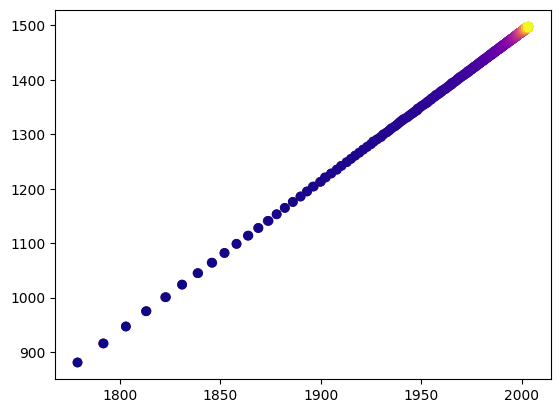

In [9]:
plt.scatter(s[0, :], s[1, :], c=p[2, :], cmap='viridis', marker='o')
plt.scatter(s_pixel[0, :], s_pixel[1, :], c=p[2, :], cmap='plasma', marker='o')

## Calibration
Below we go through calibration

In [10]:
normals = calculate_normals(p)

normals

array([[ 0.85771824,  0.1945646 ,  0.47588238],
       [-0.72840603, -0.6070528 ,  0.31766579],
       [-0.98191181,  0.15642695,  0.10667619],
       ...,
       [-0.93512886,  0.33491811,  0.11560225],
       [-0.13968815, -0.90752299,  0.39609248],
       [ 0.15638433,  0.98552139,  0.06550972]], shape=(1000, 3))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

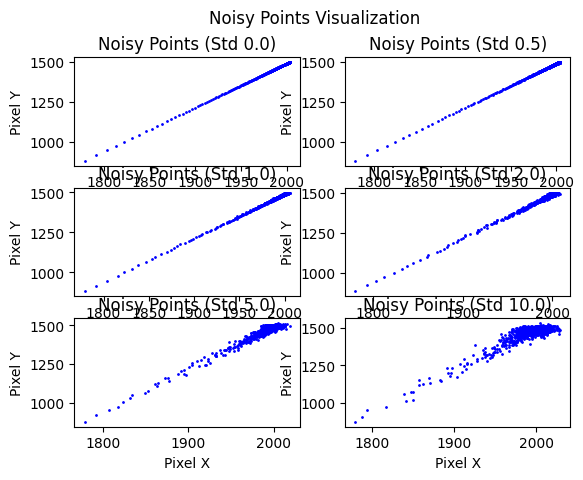

In [11]:
np.random.seed(0)

calibrations_by_stds = []
stds = [0.0, 0.5, 1.0, 2.0, 5.0, 10.0]

fig, axs = plt.subplots(3, 2)
fig.suptitle('Noisy Points Visualization')

for idx, std in enumerate(tqdm(stds)):
    x, y = divmod(idx, 2)
    ax = axs[x, y]

    s_noisy = np.random.normal(s, std, s.shape)
    rays = inverted_camera_intrinsics @ s_noisy
    scale_factor = np.einsum('ij,ij->j', normals.T, p) / np.einsum('ij,ij->j', normals.T, rays)
    p_noisy = rays * scale_factor

    s_pixel_noisy = np.random.normal(s_pixel, std, s_pixel.shape)
    s_pixel_noisy = np.round(s_pixel_noisy)
    rays_pixel = inverted_camera_intrinsics @ s_pixel_noisy
    scale_factor_pixel = np.einsum('ij,ij->j', normals.T, p) / np.einsum('ij,ij->j', normals.T, rays_pixel)
    p_pixel_noisy = rays_pixel * scale_factor_pixel

    calibrations = []
    calibrations_pixels = []
    for n in tqdm(list(range(2, STEP_COUNT))):
        idxs = np.random.choice(np.arange(STEP_COUNT), n, replace=False)

        local_laser_origin, local_laser_orientation = calibrate_laser(p_noisy[:, idxs].T)
        calibration_noisy = np.concatenate([local_laser_orientation, local_laser_origin[:2]])

        local_laser_origin_pixel, local_laser_orientation_pixel = calibrate_laser(p_pixel_noisy[:, idxs].T)
        calibration_pixel_noisy = np.concatenate([local_laser_orientation_pixel, local_laser_origin_pixel[:2]])

        calibrations.append(calibration_noisy)
        calibrations_pixels.append(calibration_pixel_noisy)

    ax.set_title(f'Noisy Points (Std {std})')
    ax.set_xlabel('Pixel X')
    ax.set_ylabel('Pixel Y')
    ax.scatter(s_noisy[0, :], s_noisy[1, :], c='blue', s=1, label='Noisy Points')

    calibrations_by_stds.append((std, calibrations, calibrations_pixels))

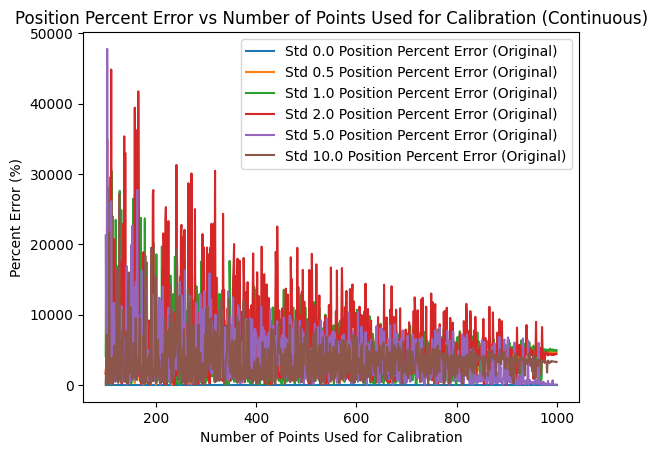

In [12]:
_ = plot_position_percent_error({
    "Original/solid": [(std, arrays) for std, arrays, _ in calibrations_by_stds],
}, laser_params, STEP_COUNT, "Continuous", start=100)

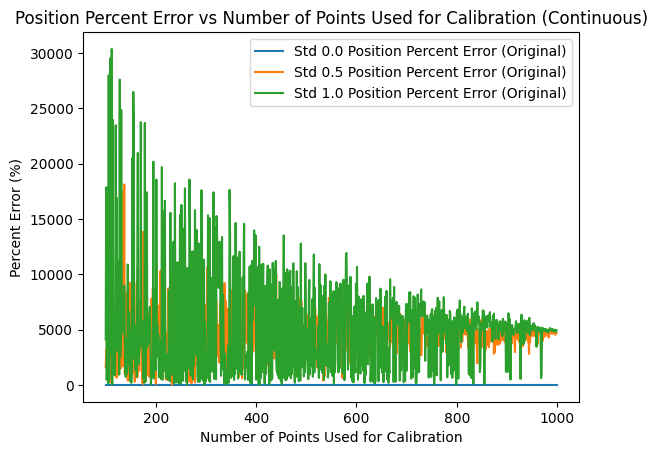

In [13]:
_ = plot_position_percent_error({
    "Original/solid": [(std, arrays) for std, arrays, _ in calibrations_by_stds[0:3]],
}, laser_params, STEP_COUNT, "Continuous", start=100)

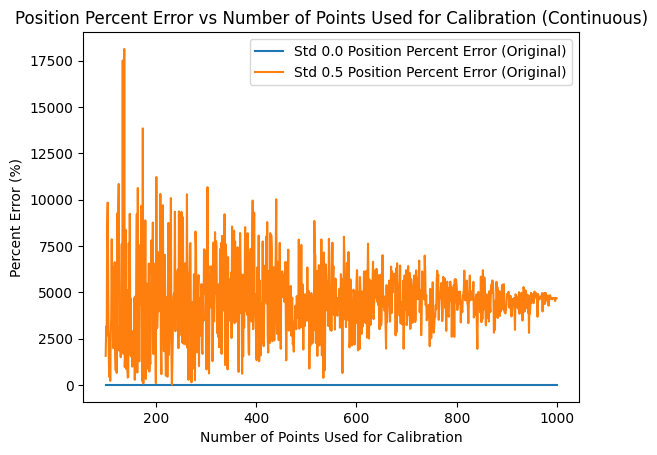

In [14]:
_ = plot_position_percent_error({
    "Original/solid": [(std, arrays) for std, arrays, _ in calibrations_by_stds[0:2]],
}, laser_params, STEP_COUNT, "Continuous", start=100)

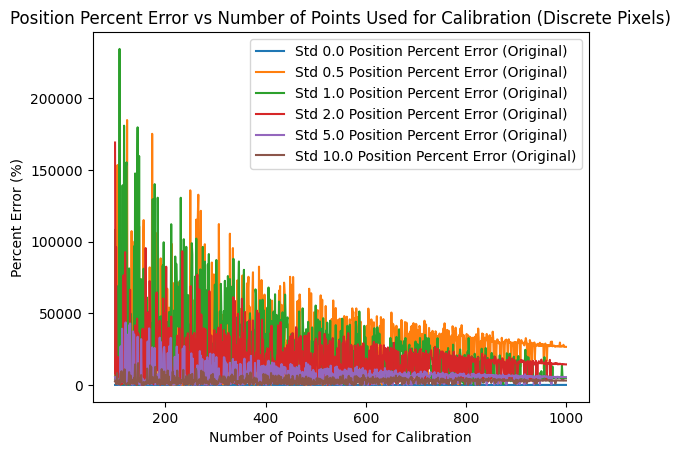

In [15]:
_ = plot_position_percent_error({
    "Original/solid": [(std, arrays) for std, _, arrays in calibrations_by_stds],
}, laser_params, STEP_COUNT, "Discrete Pixels", start=100)

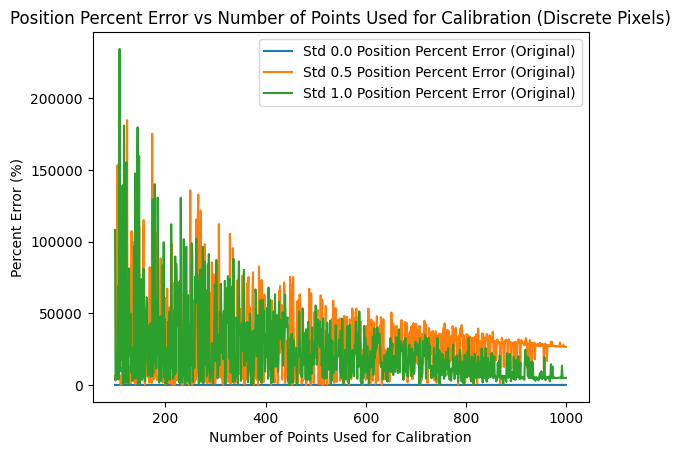

In [16]:
_ = plot_position_percent_error({
    "Original/solid": [(std, arrays) for std, _, arrays in calibrations_by_stds[:3]],
}, laser_params, STEP_COUNT, "Discrete Pixels", start=100)

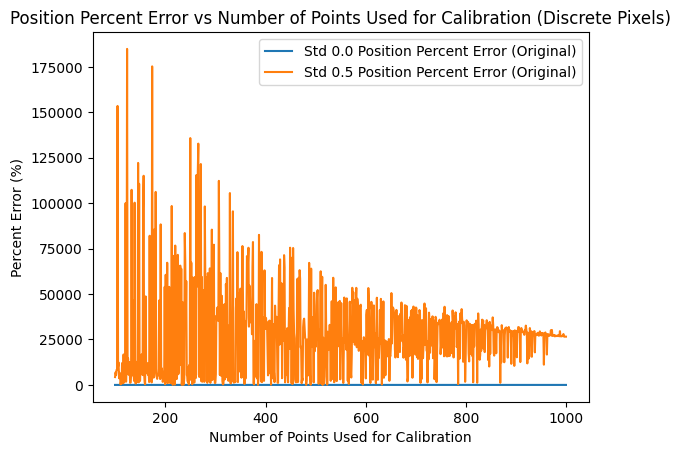

In [17]:
_ = plot_position_percent_error({
    "Original/solid": [(std, arrays) for std, _, arrays in calibrations_by_stds[:2]],
}, laser_params, STEP_COUNT, "Discrete Pixels", start=100)

## Testing Each Calibration

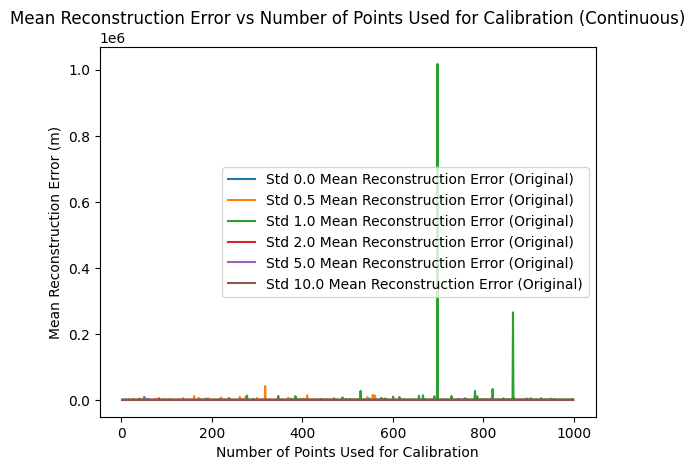

In [18]:
_ = plot_mean_reconstruction_error({
    "Original/solid": [(std, arrays) for std, arrays, _ in calibrations_by_stds],
}, inverted_camera_intrinsics, s, p, STEP_COUNT, "Continuous")

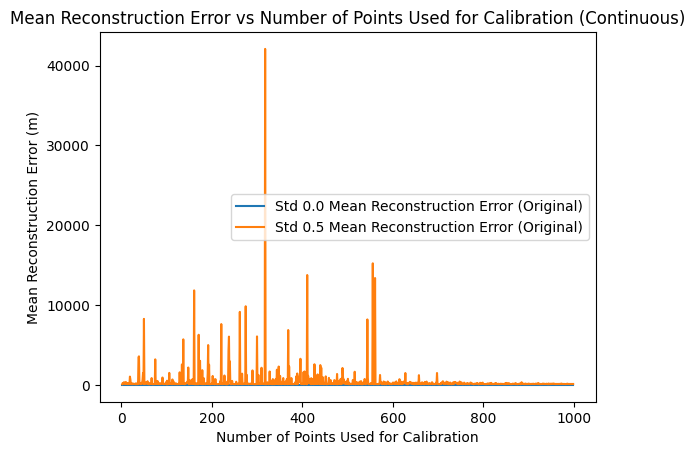

In [19]:
_ = plot_mean_reconstruction_error({
    "Original/solid": [(std, arrays) for std, arrays, _ in calibrations_by_stds[:2]],
}, inverted_camera_intrinsics, s, p, STEP_COUNT, "Continuous")

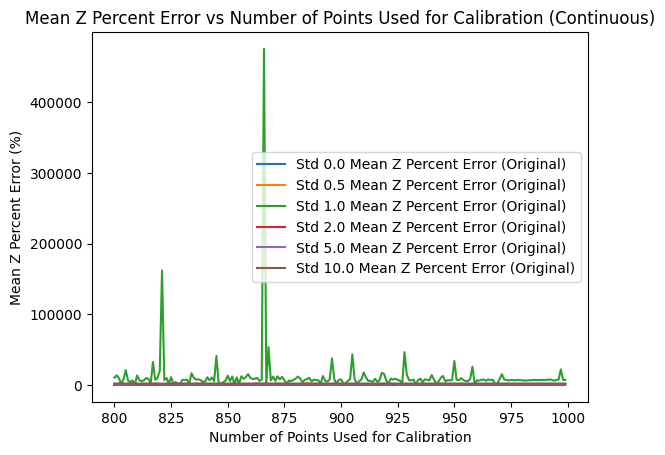

In [20]:
_ = plot_mean_z_percent_error({
    "Original/solid": [(std, arrays) for std, arrays, _, in calibrations_by_stds],
}, inverted_camera_intrinsics, s, p, STEP_COUNT, "Continuous", start=800)

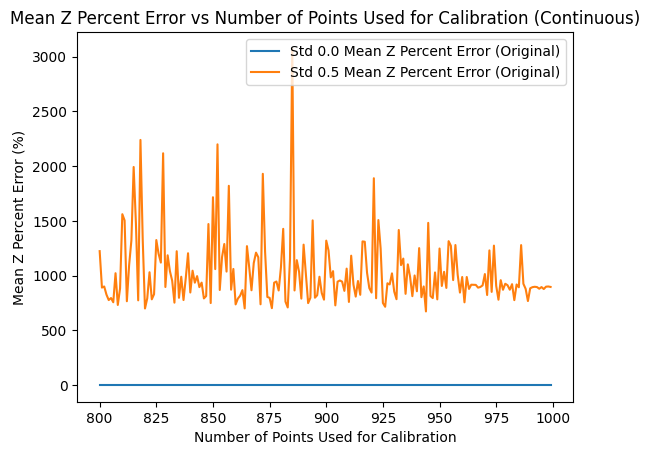

In [21]:
_ = plot_mean_z_percent_error({
    "Original/solid": [(std, arrays) for std, arrays, _ in calibrations_by_stds[:2]],
}, inverted_camera_intrinsics, s, p, STEP_COUNT, "Continuous", start=800)

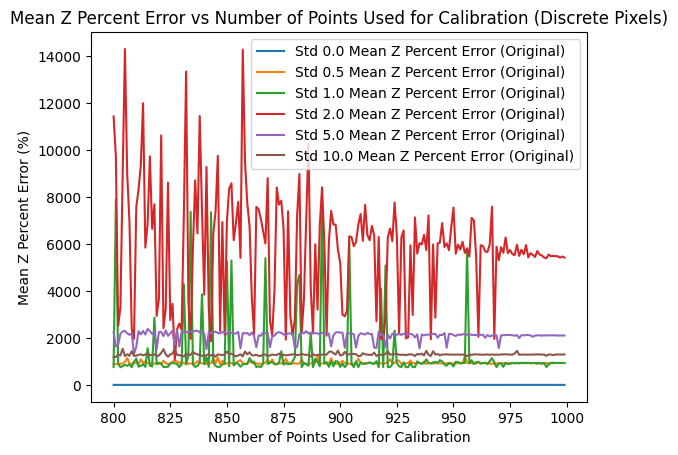

In [22]:
_ = plot_mean_z_percent_error({
    "Original/solid": [(std, arrays) for std, _, arrays in calibrations_by_stds],
}, inverted_camera_intrinsics, s, p, STEP_COUNT, "Discrete Pixels", start=800)

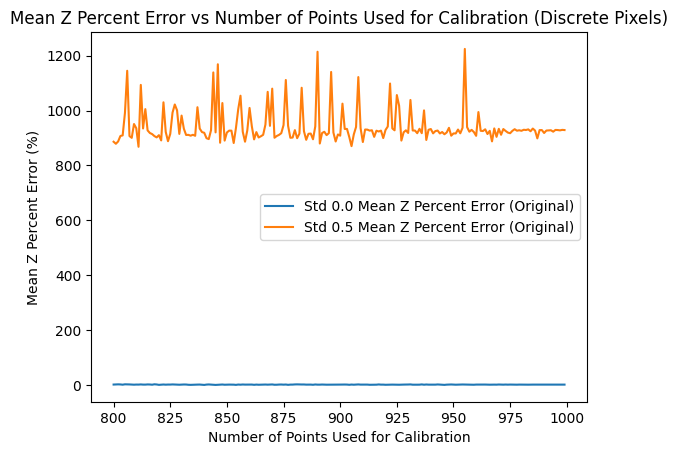

In [23]:
_ = plot_mean_z_percent_error({
    "Original/solid": [(std, arrays) for std, _, arrays in calibrations_by_stds[:2]],
}, inverted_camera_intrinsics, s, p, STEP_COUNT, "Discrete Pixels", start=800)